# Classification

## Setup

In [116]:
import sklearn
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# to plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize = 14)
mpl.rc("xtick", labelsize = 12)
mpl.rc("ytick", labelsize = 12)

## MNIST

We will be using the MNIST dataset, which is a set of 70,000 small
images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “Hello World” of Machine Learning

Scikit-Learn provides many helper functions to download popular datasets. MNIST is
one of them. The following code fetches the MNIST dataset

In [117]:
from sklearn.datasets import fetch_openml


# Warning: since Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default. To avoid this and keep the same code as in the book, we use as_frame=False

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist

c:\Users\DELL\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'categories': {},
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixe

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:

-  A `DESCR` key describing the dataset
- A `data` key containing an array with one row per instance and one column per feature
-  A `target` key containing an array with the labels

Let’s look at these arrays:

In [118]:
X, y = mnist["data"], mnist["target"]

In [119]:
X.shape

(70000, 784)

In [120]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image
is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black).

Let’s take a peek at one digit from the dataset. 

All you need to
do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using
Matplotlib’s imshow() function:

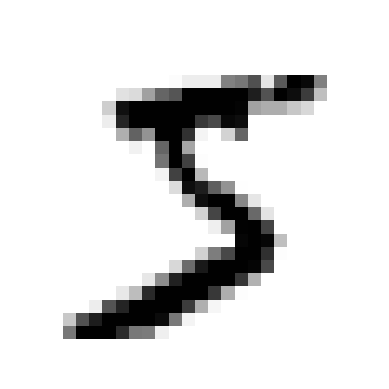

In [121]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [122]:
y[0]

'5'

In [123]:
y = y.astype(np.uint8)

In [124]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

In [125]:
import math

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row )
    n_rows = math.ceil(len(instances) / images_per_row)
    
    # Append empty images to fill the end of the grid, if needed
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size*size))], axis=0)
    
    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    
    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

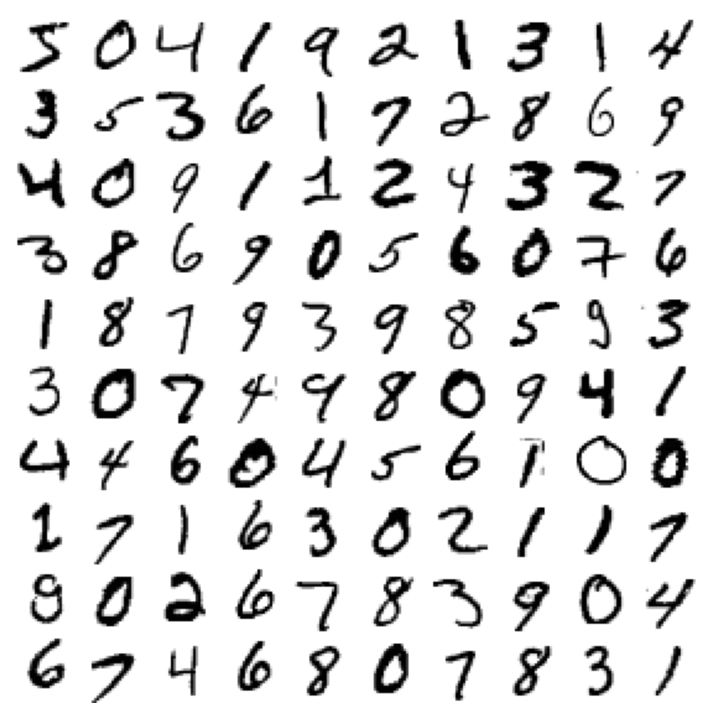

In [126]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

 The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images)

In [127]:
X_train, X_test , y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will
be similar (you don’t want one fold to be missing some digits)

In [128]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5.

Let’s create the target vectors for
this classification task

In [129]:
y_train_5 = (y_train == 5) # True for all 5s, False for other digits
y_test_5 = (y_test == 5)

Okay, now let’s pick a classifier and train it. A good place to start is with a `Stochastic Gradient Descent` (SGD) classifier, using Scikit-Learn’s `SGDClassifier` class.

This classifier has the advantage of being capable of handling very large datasets efficiently.
This is in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning).

Let’s create
an `SGDClassifier` and train it on the whole training set

In [130]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now you can use it to detect images of the number 5:

In [131]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right
in this particular case! Now, let’s evaluate this model’s performance.

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we
will spend a large part of this chapter on this topic

### Measuring Accuracy using Cross-Validation

#### (Extra) Implementing Cross-Validation

Occasionally you will need more control over the cross-validation process than what
`cross_val_score()` and similar functions provide. In these cases, you can implement
cross-validation yourself. 

In [132]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Provides train/test indices to split data in train/test sets

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96285
0.96195
0.9563


The `StratifiedKFold` class performs stratified sampling 
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions.

Let’s use the `cross_val_score()` function to evaluate your `SGDClassifier` model
using K-fold cross-validation, with three folds. Remember that K-fold cross-validation means splitting the training set into K-folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the
remaining folds. 

In [133]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9681 , 0.95655, 0.95515])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? 
This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class

In [134]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [135]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with *skewed datasets* (i.e., when some
classes are much more frequent than others)

### Confusion Matrix

Better way to evaluate performance of classifier. General idea is to count the number of times instances of class A are classified as class B.

For example: To check how many times our classifier confused images of 5s as 3s, is to look the matrix in 5th row 3rd column

To compute confusion matrix we need a set to predictions, so that they can be compared with the actual targets. One way is to make predictions on test case, but it is better not to use test case now (Remember use test case only when the model is finally ready). 

Instead we can use `cross_val_predict` function:

In [136]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like `cross_val_score` function, `cross-val_predict` performs K-fold cross-validation but instead of returning the score, it make predictions on each test fold. 

Now we are ready to make confusion matrix using `confusion_matrix()` function. Just pass target classes `y_train_5` and predicted classes `y_train_pred`

In [137]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53124,  1455],
       [  949,  4472]], dtype=int64)

Each row in confusion matrix represents an `actual class`, while each column represnets `predicted class`. 

Confusion Matrix = 
$\begin{bmatrix} \textbf{Class:} & \textbf{non-5} & \textbf{5}\\ \textbf{non-5} & 53124 & 1452\\ \textbf{5} & 949 & 4472\end{bmatrix}$

First row represents non-5 images (the negative class). 53124 of them were correctly classified as non-5s (called *true negatives*), while 1455 were wrongly classified as 5 (*false positive*).

Second row represents 5 images (the positive class). 949 of them were wrongly classified as non-5 (*false negatives*), whereas 4472 were correctly classified as 5 (*true positive*).

Confusion Matrix = 
$\begin{bmatrix}  & \textbf{Negative} & \textbf{Positive}\\ \textbf{Negative} & TN & FP\\ \textbf{Positive} & FN & TP\end{bmatrix}$

A perfect classifier would have only true positives and true negatives values, so its confusion matrix would have non zero values only in its diagonal (from top left to bottom right)

In [138]:
y_train_prefect_predictions = y_train_5 # pretend we reached perfection

confusion_matrix(y_train_5, y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

A confusion matrix gives you a lot of information, but sometimes you may prefer a concise metric.

An intresting to look at is the accuracy of positive predictions, this is called as `precision` of classifier.

$$Precision = \frac{TP}{FP+TP}$$
where $TP$ is the number of true positives and $FP$ is the number of false positives

`Precision` is typically used with another metric called `recall` also called `sensitivity` or `true positive rate (TPR)` : this is ratio of positive instances that are correctly detected by the classifier

$$ Recall = \frac{TP}{TP+FN} $$
wher $FN$ is number of false negatives

Illustration for understanding confusion matrix, precision and recall

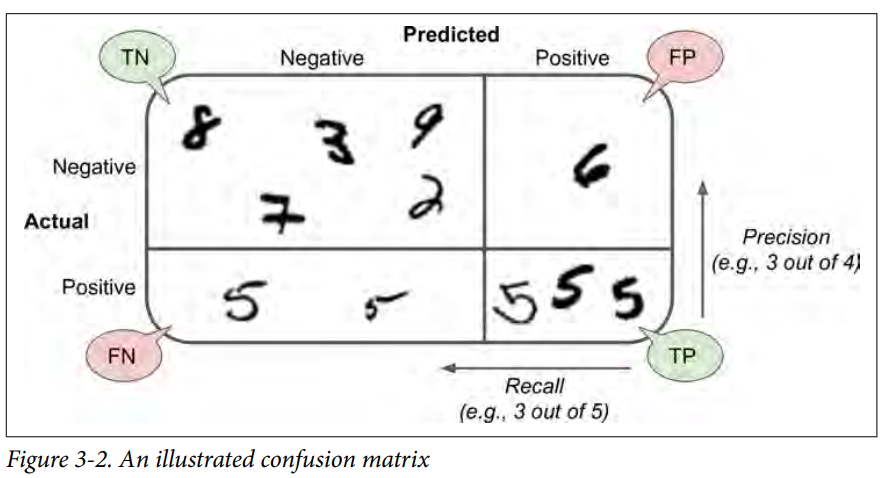

#### Precision and Recall

In [139]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.754513244474439

In [140]:
recall_score(y_train_5, y_train_pred)

0.8249400479616307

Now our 5-detector does not look as shiny as it did when we looked at the accuracy. When it claims image is 5 it is correct only 77% times moreover it only detects 82% of the 5s. 

It is often convenient to combine precision and recall into a single metric called the `F1 score`, in a particular if we need to compare two classifiers.

The `F1 score` is the harmonic mean of precision and recall

$$ 
F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision*recall}{precision+recall} = \frac{TP}{TP+\frac{FN+FP}{2}}
$$

Regular mean treats all values equally , the harmonic mean gives more weight to low values. Thus classifier will only get high $F_{1}$ when both `precision` and `recall` are high.

In [141]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7881565033486078

$F_{1}$ favours only those classifiers with similar precision and recall. 

Well that's not what we want always: in some context we mostly care about "precision" while in some other context we need only "recall".

Increasing precision reduces recall and vice-versa. This is called `precision/recall tradeoff`.

#### Precision/Recall TradeOff

To understand this, let's first understand how `SGDClassifier` works. For each instance , it computes a score based on *decision function* if it greater than threshold than it assigns it to positive class else assigns it to negative class.

Figure shows few digits positioned from lowest score on left to highest score on right

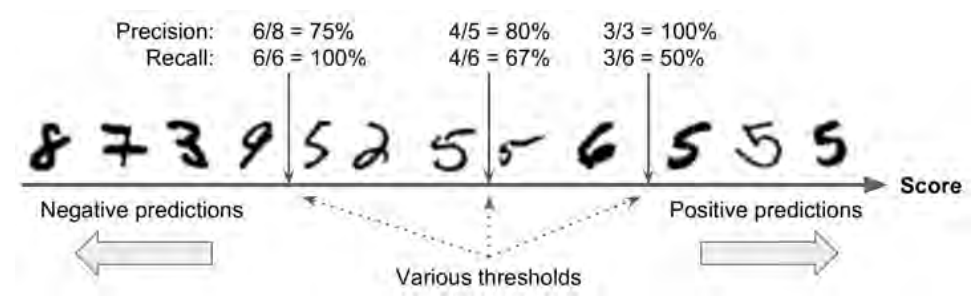

Consider a *decision threshold* is positioned at central arrow (between two 5s): then we will find 4 true positives (actual 5s) and one false positive (actually 6). Therefore with this threshold, precision is 80% (4 detected out of 5). But out of 6 actual 5s only 4 are classified so recall is 67% (4/5). 

Now let's increase the value of threshold and shift it to right of the central arrow: then we will find 3 true positives and none false positive. Thus now accuracy has been increased to 100% (3/3) whereas now one true positives becomes false negaitve thus decreasing the recall by 17%. Recall is 50% (3/6).

Similarly decreasing threshold will increase recall but will decrease accuracy. 

Scikit-learn does not directly allow us to set threshold directly but it gives us the access to decision scores that is uses to make predictions. Instead of calling predict method we call `decision_function()` method which returns a score for each instance and then we can make predictions based on that score using any threshold we want.

In [142]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3251.81547403])

In [143]:
threshold = 0
y_some_digit_pred = y_scores > threshold

y_some_digit_pred

array([ True])

Returns the same result as predict method as threshold < score. Thus correctly classified

Let's increase the threshold:

In [144]:
threshold = 8000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases the recall. The image represents 5 and classifier detects it when the threshold is 0, but it misses when it is increased to 8000

So how to decide which threshold to use? For this first we need to get socre of all the instances of training set using `cross_val_pred()` but this time specifying that we need decision scores instead of predictions

In [145]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now with these scores we can compute precision and recall with all possible values of threshold using `precision_recall_curve()` function

In [146]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally we can plot values of precision and recall as a value of threshold value

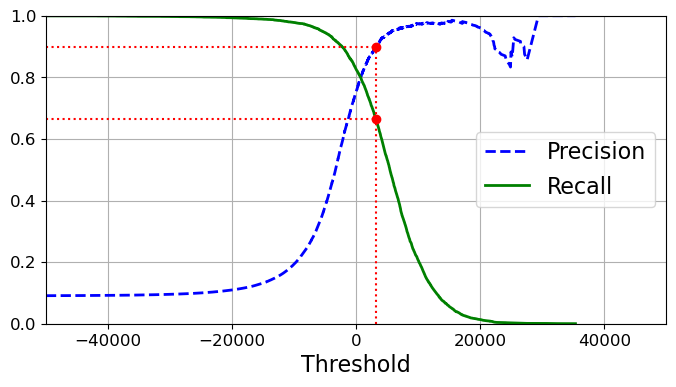

In [147]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    # plt.legend(loc="upper left")
    plt.legend(loc="center right", fontsize=16)
    plt.grid(True)
    plt.axis([-50000,50000, 0 , 1]) # set limit of x-axis and y-axis
    
 # argmax returns the indices of the first maximum element along an axis
recall_90_precision = recalls[np.argmax(precisions >= 0.90)] # this will give that first value of recall where precision is >= 0.90
threshold_90_precision = thresholds[np.argmax(precisions >=0.90)] # this will give that first value of threshold where precision is >= 0.90
   
plt.figure(figsize=(8,4))  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision,threshold_90_precision], [0.,0.9], "r:")
plt.plot([-50000,threshold_90_precision], [0.9,0.9], "r:")
plt.plot([-50000,threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot(threshold_90_precision, 0.9, "ro")
plt.plot(threshold_90_precision, recall_90_precision, "ro")

plt.show()

Precision curve is bumpier than recall curve. The reason is that precision sometimes may go down when we raise the threshold. To understand go to the figure of *Precision/Recall TradeOff* section. When we increase the threshold by only one (i.e shift from central arrow to after the 6), then precision drops down to 3/4(75%) from 4/5 (80%). On other hand, recall will only decrease on increasing threshold, thus it is more smoother as compared to precision call.

Now we can select the threshold that gives best precision/recall tradeoff for our task.

Another way to select threshold value that gives best precision/recall tradeoff is to plot precision directly against recall

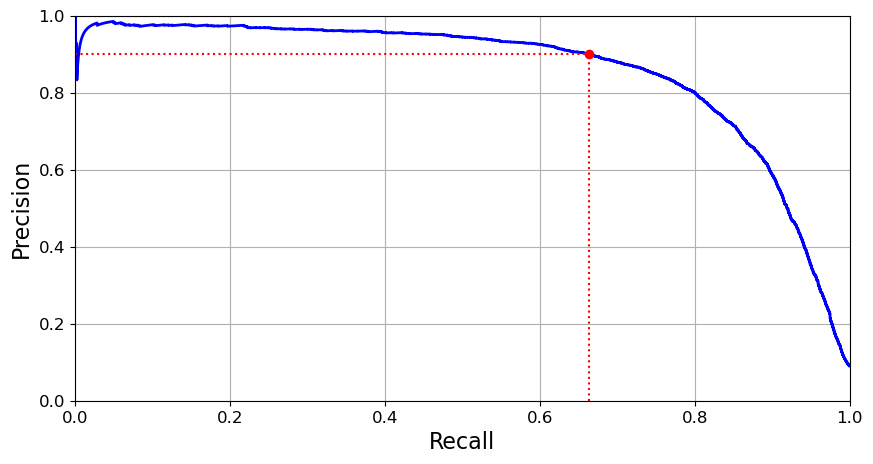

In [148]:
def plot_precision_vs_recall(precisions,recalls):
    plt.plot(recalls,precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0,1,0,1])
    plt.grid(True)

plt.figure(figsize=(10,5))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0.,0.9], "r:")
plt.plot([0, recall_90_precision], [0.9,0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

We can see from the graph that precision really starts to fall sharply around 80% recall. We want to select a precision/recall tradeoff just before that drop - say around 60% but choice highly depends on the type of project.

Let's suppose we decide to aim at 90% precision. We first look in first graph to see the value of threshold for 90% precision. 

In [149]:
threshold_90_precision

3214.584350041131

Thus value of threshold for 90% precision is around 3214. So let's take is 3220

To make predictions (on training set) as of now, instead of calling classifier's predict method, use this code instead

In [150]:
y_train_pred_90 = y_scores > threshold_90_precision

Let's check predictions precision and recall:

In [151]:
precision_score(y_train_5, y_train_pred_90)

0.8999749937484371

In [152]:
recall_score(y_train_5, y_train_pred_90)

0.6638996495111603

These two scores can be seen from the first graph also.

Great!! Now we have classifier with 90% precision (or close enough)!. Thus we can see it is very easy to create high precision classifier. Increase the threshold high enough and you are done. Hmm no so fast. A high-precision classifier is not very useful if its recall is too low!

**General NOTE:**
If someone says, "let's reach 99% precision", we should ask, "at what recall?"

### The ROC Curve

ROC (receiver operating characteristic) is another tool used with binary classifier. Similar to precision/recall curve but instead plotting precision vs recall. Plots *true postive rate* (recall) against *false positive rate*. FPR is ratio of negative instances that are incorrectly classified as positive. 

It is equal to one minus *true negative rate* which is ratio of negative instances that are correctly classified as negative. 

Thus TNR is called *specificty*. Hence ROC plots sensitivity (Recall) vs 1-*specificity*

To plot ROC curve, we first need to find TPR and FPR using `roc_curve()` function

In [153]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Now we can plot FPR vs TPR

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


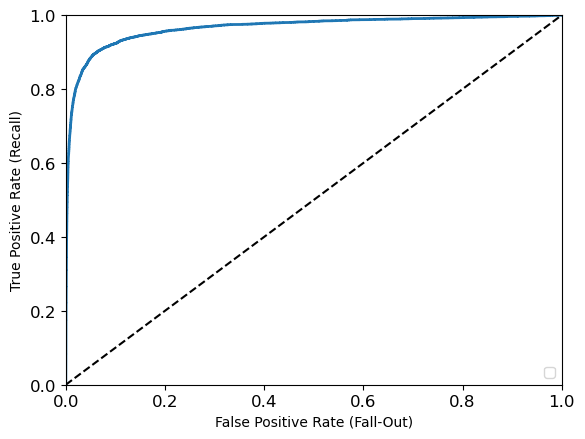

In [154]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate (Fall-Out)")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc="lower right")

plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
# plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
# plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
# plt.plot(fpr_90, recall_90_precision, "ro")
plt.show()

One again there is tradeoff, higher the TPR(Recall), the more false positives (FPR) the classifier produces.

The dotted line represents the ROC curve of purely random classifier; a good classifier always stays as far as possible (towards top left corner).

One way to compare classifier is to measure the *area under the curve* (AUC). A perfect classifier will have ROC AUC equal to 1, whereas a purely random classifer will have AUC equal to 0.5.

Scikit-Learn provides a function to compute the ROC AUC:

In [155]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9660259463088996

**TIP:**

Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. 

For example, looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the top right corner).

Let's train `RandomForestClassifier` and compare its ROC and ROC AUC score with the SGDClassifier.

First we need to get the score for each instance in the training set, but the way it works it does not have *decision_function()* instead it has `prediction_prob()` method. It returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to given class (eg. 70% chance that image represents 5)

In [156]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [157]:
y_probs_forest

array([[0.98, 0.02],
       [0.96, 0.04],
       [1.  , 0.  ],
       ...,
       [1.  , 0.  ],
       [0.95, 0.05],
       [0.98, 0.02]])

But to plot ROC we need scores not probability (remember RandomForstClassifier returns array of probability). A simple solution is to use class's probability as the score. y_probs_forest contains two columns first one is positive class (image is 5) and other is negative class (not 5)

In [158]:
y_scores_forest = y_probs_forest[:,1] # score = proba of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Now we are ready to plot ROC curve for RandomForestClassifier. It is better to plot first ROC curve as well

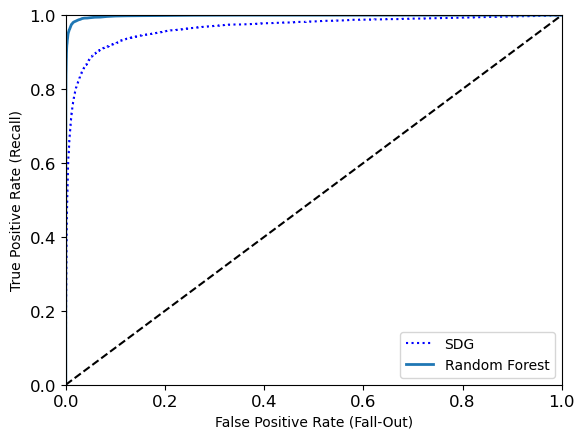

In [159]:
plt.plot(fpr, tpr, "b:", label="SDG")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.show()

As we can see, ROC curve of RandomForestClassifier looks much better than SGDClassifier, as it comes much closer to top left. As a result ROC AUC is also significantly much better

In [160]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983631764491033

Now measuring precision score and recall score

In [161]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

precision_score(y_train_5, y_train_pred_forest)

0.9890893831305078

In [162]:
recall_score(y_train_5, y_train_pred_forest)

0.8695812580704667

98.5% precision and 86.9% recall. Not too bad!

Now we know how to train binary classifiers, choose appropriate metric for our task and evaluate using cross-validation, select precision/recall tradeoff and compare various models using ROC Curve and ROC AUC scores. 

Now let's detect more than just 5s

## Multiclass Classification

Whereas binary classification can distinguish between two classes, *multiclass classification* (also called *multinomial classifiers*) can distinguish between more than two classes.

Some algorithms such as Random Forest Classifier or naive Bayes classifiers are capable of handling multiple classes diretly. Other such as Support Vector Machine classifiers or Linear classifiers are strictly binary classifiers.

However there are various strategies that we can use to perform multiclass classification using multiple binary classifiers.

For example, one way to create a system that can classify the digit images into 10 classes (0 to 9) is to train 10 binary classifiers, one for each digit (1-detector, 2-detector, 3-detector and so on). Then when you want to classify an image then get the descision score from each classifier and whoever is highest, is the one. This is called `one-versus-all` (OvA) strategy (also called `one-versus-the-rest`)

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called the `one-versus-one` (OvO) strategy. If there are N classes, you need to
train `N × (N – 1) / 2` classifiers. For the MNIST problem, this means training 45
binary classifiers! When you want to classify an image, you have to run the image
through all 45 classifiers and see which class wins the most duels.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the
size of the training set, so for these algorithms OvO is preferred since it is faster to
train many classifiers on small training sets than training few classifiers on large
training sets. For most binary classification algorithms, however, OvA is preferred.

Scikit-Learn  detects when we try to run binary classification algorithm for multiclass classification task and automatically runs OvA (excepts for SVM classifiers which uses OvO)

In [204]:
sgd_clf.fit(X_train, y_train)  # Note: y_train and not y_train_5

SGDClassifier(random_state=42)

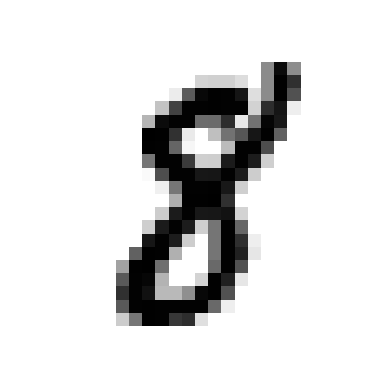

In [198]:
import random

random.seed(42) # putting seed so that in every run it generates the same number
random_number = random.randint(1,50)
some_digit_2 = X[random_number]
plot_digit(some_digit_2)

In [197]:
y[random_number]

8

As we can see the digit at random index is 8 which can be confirmed by seeing the image also. Now let's predict it using our trained SDGClassifier_2

In [205]:
sgd_clf.predict([some_digit_2])

array([8], dtype=uint8)

Yepp, that was easy! This code trains SDGClassifier on training set using the original target classes from 0 to 9 (y_train), instead 5-versus-all target classes (y_train_5). Then it makes prediction (a correct one in this case). Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and then it selected the class with the highest score.

To see that this is indeed the case, we can call `decision_function()` method. It will return 10 scores per instance.

In [206]:
some_digit_2_scores = sgd_clf.decision_function([some_digit_2])
some_digit_2_scores

array([[-24725.3862337 , -15562.58684523,  -7069.57254668,
         -4440.6868945 , -36599.69954365,  -4788.4077939 ,
         -9712.96772606, -35557.14470023,   1491.35825046,
         -4861.91415911]])

THe highest score is indeed the one corresponding to the class 8 (around 1491 score, whereas all others are in negative)

We can also use `np.argmax()` function to get the index of maximum element from the array.

In [201]:
np.argmax(some_digit_2_scores)

8

In [207]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [208]:
sgd_clf.classes_[8]

8

If we want to force Scikit-Learn to use one-versus-one or one-versus-all, we can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes. Simply create the instane and pass the binary classifier to its constructor.

For example, this code creates a multiclass classifier using the OvO strategy, based on `SGDClassifier`:

In [209]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [210]:
ovo_clf.predict([some_digit_2])

array([8], dtype=uint8)

We can use `len()` function to get the number of classifiers OvO has trained

In [211]:
len(ovo_clf.estimators_)

45

We can see that is has trained 45 classifier (0-1, 0-2, 0-3, 1-2, 1-3 and so on)

Training `RandomForestClassifier` is just as easy:

In [214]:
from sklearn.ensemble import RandomForestClassifier

forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [215]:
forest_clf.predict([some_digit_2])

array([8], dtype=uint8)

This time Scikit-Learn did not have to run OvA or OvO because Random Forest Classifer can directly classify instances into multiple classes. We can call `predict_proba()` to get the list of probabilities it has assigned to each instance for each class.

In [218]:
forest_clf.predict_proba([some_digit_2]) # here some_digit_2 = 8

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

We can see that our classifier is fairly confident about its prediction: 1.0 at 8th index means that model estimates 100% probability that image represents 8. 

We can try this with our 5 also

In [219]:
forest_clf.predict_proba([some_digit]) # here some_digit = 5

array([[0.01, 0.  , 0.03, 0.06, 0.  , 0.88, 0.  , 0.01, 0.01, 0.  ]])

Similary, 0.01 , 0.03, 0.06, 0.88 at 0th, 2nd, 3rd and 5th index means that our model estimates 1%, 3%, 6% and 88% probability that image represents 5 respectively. This means that model this there could be chance that image represents either 0 or 2 or 3 

Now of course we want to evaluate our model. As usual we will use cross validation.

In [220]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8678 , 0.88195, 0.86965])

It gets over 86% in all test folds, not a bad score!. But we can still do much better by simply scaling the inputs (as discussed in [02-Housing.ipynb](./02-Housing.ipynb)). It increases the accuracy upto 90% .

In [221]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [224]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90425, 0.9031 , 0.8903 ])

We can around 90% accuracy has been achieved in each test fold

## Error Analysis